On Epoch 1/50, we got an error of -> 0.170061
On Epoch 5/50, we got an error of -> 0.047787
On Epoch 10/50, we got an error of -> 0.024877
On Epoch 15/50, we got an error of -> 0.016399
On Epoch 20/50, we got an error of -> 0.012689
On Epoch 25/50, we got an error of -> 0.010487
On Epoch 30/50, we got an error of -> 0.008695
On Epoch 35/50, we got an error of -> 0.007662
On Epoch 40/50, we got an error of -> 0.006739
On Epoch 45/50, we got an error of -> 0.006373
On Epoch 50/50, we got an error of -> 0.005528


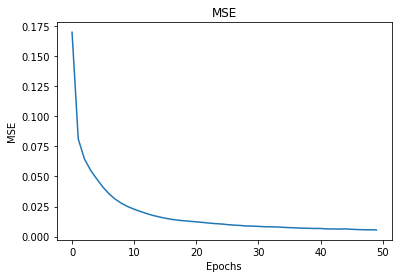

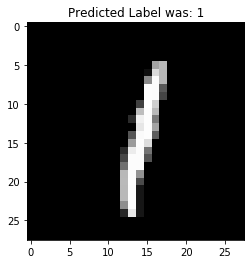

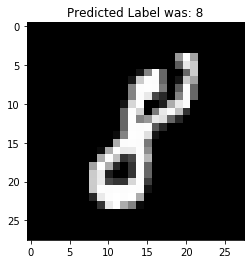

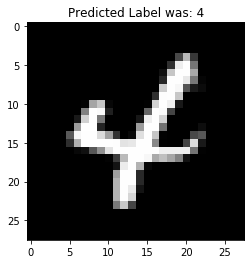

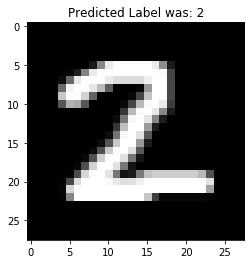

In [21]:
from keras.datasets import mnist
from keras.utils import np_utils
import numpy as np
import cv2 as cv
import math
import matplotlib.pyplot as plt
%matplotlib inline

# ------------------------------------------------------------------------------- #

"""
    Used a Base Layer Class:
    Because every layer (does not matter if activation or fully connected)
    implements forward propagation and back propagation in its way.
"""
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
        
    def forward_prop(self, input):
        """
            Uses to compute the output of a given input,
            in other words, evaluate in the classic y = b + Sum(x*W)
            if not implemented, throw an error.
        """
        raise NotImplementedError
    
    def backward_prop(self, output_error, lr):
        """
            Implementation of the backward Propagation,
            We need the output error and the learning rate in 
            order to calculate this.
        """
        raise NotImplementedError

# -------------------------------------------------------------------------------- #
        
"""
    Creating a Fully Connected Layer making use of the
    class made for a base layer
"""
class FCLayer(Layer):
    def __init__(self, input_size, output_size):
        """
            Initialize the Weights and the Bias for each FC Layer.
            In order to make it better, values are initialized randomly.
            W is shape (number of input neurons, number of output neurons)
            b is shape (1, number of output neurons)
        """
        self.W = np.random.rand(input_size, output_size) - 0.5
        self.b = np.random.rand(1, output_size) - 0.5
        
    def forward_prop(self, input_data):
        """
            Simply applies the forward propagation formula.
            Meaning:
                Xw + b
        """
        self.input = input_data
        self.output = self.input@self.W + self.b
        return self.output
    
    def backward_prop(self, output_error, lr):
        """
            Calculates the error using derivatives:
            
            First the error with respect to the input:
                Which is the dot product of the output error and the
                transpose of the weights.
            Second is the weights error:
                Which is the dot product between the input transposed
                and the output_error.
            Third is the bias error:
                This one is just equal to the error with respect to the
                output.
        """
        input_error = output_error@self.W.T
        w_error = self.input.T@output_error
        
        self.W -= lr * w_error
        self.b -= lr * output_error
        return input_error
    
# -------------------------------------------------------------------------------- #
    
class ActivationLayer(Layer):
    def __init__(self, activation, activation_):
        """
            Defines the Activation which is going to be used:
                In this case it will be tanh.
            Also, we need the derivative of the activation, which in
            this case is represented as activation_
            We are using derivatives because that is how we propagate
            the error.
        """
        self.activation = activation
        self.activation_ = activation_
        
    def forward_prop(self, input_data):
        """
            Simply passes the input through the activaction function.
        """
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output
    
    def backward_prop(self, output_error, lr):
        """
            Applies an element-wise multiplication between the
            input passed through the derivative of the activation function
            and the output error.
        """
        return self.activation_(self.input) * output_error

# -------------------------------------------------------------------------------- #

"""
    Useful Functions including:
        Activation functions (tanh, sigmoid)
        Derivatives of the activations (tanh_, sigmoid_)
        Mean Square Error.
"""

def tanh(x):
    return np.tanh(x)

def tanh_(x):
    return 1-np.tanh(x)**2

def sigmoid(x):
    return 1/(1+np.exp(-1*x))

def sigmoid_(x):
    return np.exp(-1*x)/(1+np.exp(x))**2

def mse(real_y, pred_y):
    return np.mean(np.power(real_y - pred_y, 2))

def mse_(real_y, pred_y):
    return 2*(pred_y-real_y)/real_y.size

# -------------------------------------------------------------------------------- #

"""
    Class for making the actual network.
    Making a list of the layers and control the learning process and 
    the prediction of a value.
"""

class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_ = None
        
    def add(self, layer):
        self.layers.append(layer)
    
    def use(self, loss, loss_):
        """
            Selects what loss function to used.
            In this case the mse function will be passed
            as an argument in this function.
        """
        self.loss = loss
        self.loss_ = loss_
    
    def predict(self, input_data):
        m = len(input_data)
        result = []
        
        for i in range(m):
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_prop(output)
            result.append(output)
        
        return result
    
    def fit(self, x_train, y_train, epochs, lr):
        m = len(x_train)
        
        for i in range(epochs):
            error_ = 0
            for j in range(m):
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_prop(output)
                
                error_ += self.loss(y_train[j], output)
                error = self.loss_(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_prop(error, lr)
                    
            error_ /= m
            __errors__.append(error_)
            if(((i+1)%5==0) or i==0):
                print('On Epoch %d/%d, we got an error of -> %f' % (i+1, epochs, error_))
                

# -------------------------------------------------------------------------------- #                
"""
    Loading and rearranging the data from Mnist.
    Normalizing it and changing the type to float32 in order to be processed.
"""
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255

y_train = np_utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255

y_test = np_utils.to_categorical(y_test)

__errors__ = []
epochs = 50

"""
    Designing and implementing the network.
    Using its functions to add layers and to train.
"""

network = Network()
network.add(FCLayer(28*28, 100))
network.add(ActivationLayer(tanh, tanh_))
network.add(FCLayer(100,50))
network.add(ActivationLayer(tanh, tanh_))
network.add(FCLayer(50,10))
network.add(ActivationLayer(tanh, tanh_))

network.use(mse, mse_)
network.fit(x_train[0:2000], y_train[0:2000], epochs = 50, lr=0.1)

plt.plot(range(epochs), __errors__)
plt.title('MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

# -------------------------------------------------------------------------------- #
# --------------- FINISHED TRAINING -> STARTING TESTING -------------------------- #
# -------------------------------------------------------------------------------- #

for i in range(3):
    index = np.random.randint(10000)
    out = network.predict(x_test[index])
    label = np.argmax(out)
    image = x_test[index]
    pixels = np.array(image)
    pixels = pixels.reshape((28,28))
    plt.title('Predicted Label was: {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')
    plt.show()
    
# -------------------------------------------------------------------------------- #
# ---------------------------- STARTING OWN TEST --------------------------------- #
# -------------------------------------------------------------------------------- #    
    
file = "Samples/Own2.png"
test = cv.imread(file, cv.IMREAD_GRAYSCALE)
gray = test

while np.sum(gray[0]) == 0:
    gray = gray[1:]

while np.sum(gray[:,0]) == 0:
    gray = np.delete(gray,0,1)

while np.sum(gray[-1]) == 0:
    gray = gray[:-1]

while np.sum(gray[:,-1]) == 0:
    gray = np.delete(gray,-1,1)

rows,cols = gray.shape

if rows > cols:
    factor = 20.0/rows
    rows = 20
    cols = int(round(cols*factor))
    gray = cv.resize(gray, (cols,rows))
else:
    factor = 20.0/cols
    cols = 20
    rows = int(round(rows*factor))
    gray = cv.resize(gray, (cols, rows))
    
colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')

# -------------------------------------------------------------------------------- #
# ------------------------- PLOTTING AND PREDICTING ------------------------------ #
# -------------------------------------------------------------------------------- #

plt.imshow(gray, cmap='gray')
gray = gray.reshape(1, 784)
label = network.predict(gray)
label = np.argmax(label)
plt.title('Predicted Label was: {label}'.format(label=label))
plt.show()

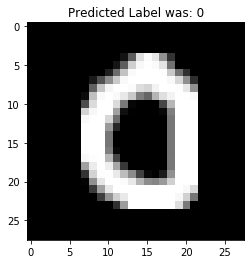

In [20]:
# -------------------------------------------------------------------------------- #
# ---------------------------- STARTING OWN TEST --------------------------------- #
# -------------------------------------------------------------------------------- #    
    
file = "Samples/Own.png"
test = cv.imread(file, cv.IMREAD_GRAYSCALE)
gray = test

while np.sum(gray[0]) == 0:
    gray = gray[1:]

while np.sum(gray[:,0]) == 0:
    gray = np.delete(gray,0,1)

while np.sum(gray[-1]) == 0:
    gray = gray[:-1]

while np.sum(gray[:,-1]) == 0:
    gray = np.delete(gray,-1,1)

rows,cols = gray.shape

if rows > cols:
    factor = 20.0/rows
    rows = 20
    cols = int(round(cols*factor))
    gray = cv.resize(gray, (cols,rows))
else:
    factor = 20.0/cols
    cols = 20
    rows = int(round(rows*factor))
    gray = cv.resize(gray, (cols, rows))
    
colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')

# -------------------------------------------------------------------------------- #
# ------------------------- PLOTTING AND PREDICTING ------------------------------ #
# -------------------------------------------------------------------------------- #

plt.imshow(gray, cmap='gray')
gray = gray.reshape(1, 784)
label = network.predict(gray)
label = np.argmax(label)
plt.title('Predicted Label was: {label}'.format(label=label))
plt.show()